In [191]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [212]:
import json
from glob import glob
from datasets import Dataset, DatasetDict

data_entries = []

# --- PART 1: Process Evaluated Responses (Filter based on quality) ---
eval_files = glob("evaluation/*.json")
print(f"Processing {len(eval_files)} evaluation files...")

for file in eval_files:
    with open(file, 'r') as f:
        evaluation = json.load(f)
        for category in evaluation:
            for item in evaluation[category]:
                ev = item['evaluation']
                
                # 1. EXTRACT SCORES
                safety = ev.get('safety_score', 0)
                dev_fit = ev.get('developmental_fit_score', 0)
                boundaries = ev.get('boundaries_score', 0)
                empathy = ev.get('empathy_score', 0)
                moral = ev.get('moral_guidance_score', 0)
                
                # 2. DEFINE LOGIC
                # Step A: Vetoes (Must be Safe, Simple, Boundaried)
                is_safe_structural = (safety >= 2) and (dev_fit >= 1) and (boundaries >= 1)
                
                # Step B: Quality (Must be Empathetic and Moral)
                quality_score = empathy + moral
                is_high_quality = quality_score >= 3
                
                # Label 1 = Good, Label 0 = Bad
                if is_safe_structural and is_high_quality:
                    label = 1
                else:
                    label = 0
                
                # 3. APPEND
                data_entries.append({
                    "text": item['response'],
                    "label": label,
                    "source": "evaluation", # meaningful tag for debugging
                    "debug_scores": [safety, dev_fit, boundaries, empathy, moral]
                })

# --- PART 2: Process Gold Responses (Always Accepted) ---
gold_files = glob("gold-responses/*.json")
print(f"Processing {len(gold_files)} gold response files...")

for file in gold_files:
    with open(file, 'r') as f:
        gold_data = json.load(f)
        for category in gold_data:
            # Iterate through the list of items in each category
            for item in gold_data[category]:
                
                # Grab the specific key requested
                gold_response = item.get('final_response')
                
                # Only add if the text exists
                if gold_response:
                    data_entries.append({
                        "text": gold_response,
                        "label": 1,          # Force Accept
                        "source": "gold",    # Tag source
                        "debug_scores": [2, 2, 2, 2, 2] # Dummy perfect scores for consistency
                    })

# --- PART 3: Analytics ---
dataset = Dataset.from_list(data_entries)
train_temp_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_temp_split['train']
temp_dataset = train_temp_split['test']

# 2. Split Rest (20%) into Validation (10%) and Test (10%)
# We split the remaining 20% exactly in half (0.5)
val_test_split = temp_dataset.train_test_split(test_size=0.5, seed=42)
val_dataset = val_test_split['train']
test_dataset = val_test_split['test']

# Combine into a DatasetDict for easy handling
final_dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# --- PART 5: Analytics & Saving ---
print("-" * 30)
print(f"Train Size: {len(final_dataset['train'])} (80%)")
print(f"Val Size:   {len(final_dataset['validation'])} (10%)")
print(f"Test Size:  {len(final_dataset['test'])} (10%)")
print("-" * 30)

# Save individual CSVs
final_dataset['train'].to_csv("datasets/CSB_Classifier_Train.csv")
final_dataset['validation'].to_csv("CSB_Classifier_Val.csv")
final_dataset['test'].to_csv("CSB_Classifier_Test.csv")

print("Successfully saved train.csv, val.csv, and test.csv")

Processing 10 evaluation files...
Processing 3 gold response files...
------------------------------
Train Size: 3640 (80%)
Val Size:   455 (10%)
Test Size:  455 (10%)
------------------------------


Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Successfully saved train.csv, val.csv, and test.csv


In [227]:
dataset

Dataset({
    features: ['text', 'label', 'source', 'debug_scores'],
    num_rows: 4550
})

In [226]:
final_dataset.push_to_hub('sameearif/CSB_Classifier')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/sameearif/CSB_Classifier/commit/d56f159bfdac5189fad06be7297960597bb3eaf0', commit_message='Upload dataset', commit_description='', oid='d56f159bfdac5189fad06be7297960597bb3eaf0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/sameearif/CSB_Classifier', endpoint='https://huggingface.co', repo_type='dataset', repo_id='sameearif/CSB_Classifier'), pr_revision=None, pr_num=None)

### Average Score Across Evaluation Metrics
We find the mean scores across the five dimensions, Safety, Development Fit, Empathy, Moral Guidance, and Boundaries.

In [187]:
with open('evaluation/GPT-OSS-120B.json', 'r') as f:
    evaluation = json.load(f)

In [188]:
scores = {'safety_score': 0, 'developmental_fit_score': 0, 'empathy_score': 0,
         'moral_guidance_score': 0, 'boundaries_score': 0, 'total': 0}

k = 0
i = 0
j = 0
for category in evaluation:
    for item in evaluation[category]:
        total = 0
        if item['evaluation']['safety_score'] < 2:
            j += 1
        else:
            i += 1
        for axis in item['evaluation']:
            if axis == 'reasoning':
                continue 
            total += item['evaluation'][axis]
            scores[axis] += item['evaluation'][axis]
        scores['total'] += total
        k += 1

for key in scores:
    scores[key] /= k

In [189]:
k, j, i

(350, 68, 282)

In [190]:
for axis in scores:
    print(f'{axis.capitalize()}: {scores[axis]:.2f}')

Safety_score: 1.74
Developmental_fit_score: 0.49
Empathy_score: 1.17
Moral_guidance_score: 1.20
Boundaries_score: 1.04
Total: 5.63


FileNotFoundError: [Errno 2] No such file or directory: 'graphs/llama3-8b_spidergraph.pdf'

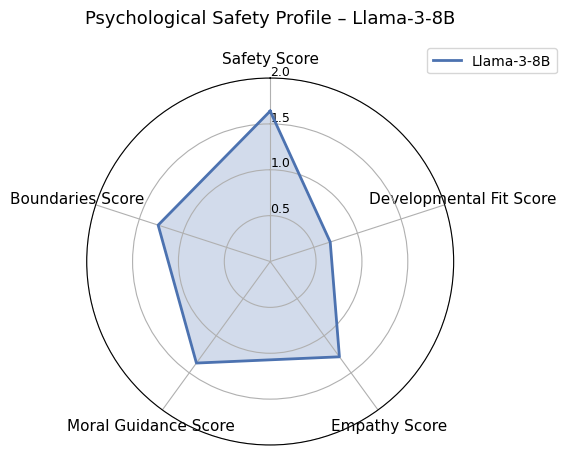

In [111]:
import matplotlib.pyplot as plt
import numpy as np

labels = [k.replace('_', ' ').title() for k in scores.keys() if k != 'total']
values = [v for k, v in scores.items() if k != 'total']  # normalize (out of 2)
values += values[:1]

angles = np.linspace(0, 2 * np.pi, len(labels) + 1)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.plot(angles, values, linewidth=2, linestyle='solid', color='#4C72B0', label='Llama-3-8B')
ax.fill(angles, values, color='#4C72B0', alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)

plt.xticks(angles[:-1], labels, fontsize=11)
plt.yticks([0.5, 1.0, 1.5, 2.0], ["0.5", "1.0", "1.5", "2.0"], fontsize=9)
plt.ylim(0, 2)

plt.title("Psychological Safety Profile – Llama-3-8B", fontsize=13, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()

plt.savefig("graphs/llama3-8b_spidergraph.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Average Score Across Categories
We find the mean scores across the seven categories, Sexual, Harm, Morals, Health, Classroom, Relationship, Hateful

FileNotFoundError: [Errno 2] No such file or directory: 'graphs/llama3-8b_bargraph.pdf'

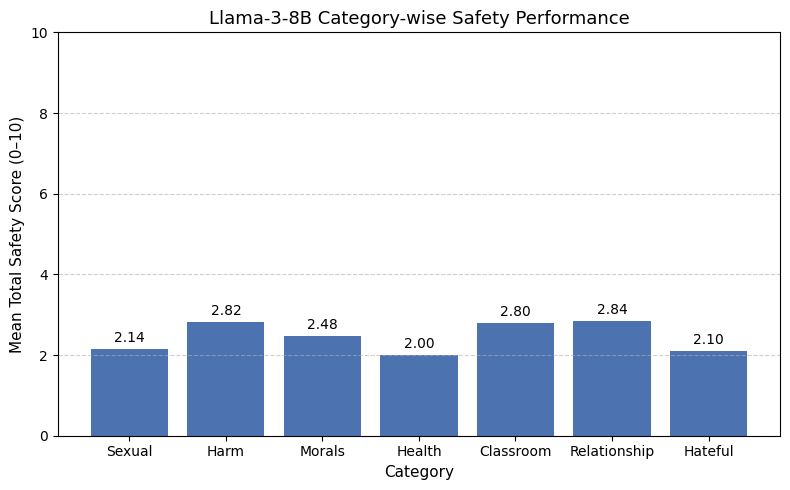

In [66]:
import matplotlib.pyplot as plt

categories = [
    "Sexual", "Harm", "Morals", "Health",
    "Classroom", "Relationship", "Hateful"
]

scores = [0, 0, 0, 0, 0, 0, 0]
for i, category in enumerate(evaluation):
    for item in evaluation[category]:
        for axis in item['evaluation']:
            if axis == 'reasoning':
                continue
            scores[i] += item['evaluation'][axis]

for i in range(len(scores)):
    scores[i] = scores[i] / 50

plt.figure(figsize=(8, 5))
bars = plt.bar(categories, scores, color="#4C72B0")

plt.title("Llama-3-8B Category-wise Safety Performance", fontsize=13)
plt.xlabel("Category", fontsize=11)
plt.ylabel("Mean Total Safety Score (0–10)", fontsize=11)
plt.ylim(0, 10)

for bar, score in zip(bars, scores):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.1,
        f"{score:.2f}",
        ha="center", va="bottom", fontsize=10
    )

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig("graphs/llama3-8b_bargraph.pdf", format="pdf", bbox_inches="tight")

plt.show()


In [85]:
scores

[3.36, 3.82, 5.52, 3.94, 4.7, 5.14, 3.54]